# Source localization problem
You are given a square domain in which there are placed sensors. An impulse source is placed in the domain and fires at $T_{trigger}$. Each sensor registers the time it has received the impulse. Find the position of the source, if the propagation dynamic is:

$$ T_i = T_{trigger} + \sqrt{(\frac{x - x_i}{v_x})^2 + (\frac{y - y_i}{v_y})^2} $$

where $(x,y)$ is the position of the source

In [1]:
import numpy as np
import scipy.optimize as opt
import matplotlib.pyplot as plt

In [2]:
from loss import *
from problem import *

## Visualization

In [3]:
def compute_activation_field(problem: SingleSourceProblem, mesh: np.ndarray):
    xx, yy = np.meshgrid(mesh, mesh)

    return compute_arrival_time(
        np.array([xx, yy]).T,
        problem.velocity,
        problem.trigger_time,
        problem.source_location
    ).T

In [4]:
def plot_problem(problem: SingleSourceProblem, resolution: int = 128):
    mesh = np.linspace(-L, L, num=resolution)
    T = compute_activation_field(problem, mesh)

    plt.pcolormesh(mesh, mesh, T)
    plt.colorbar()
    
    plt.scatter(
        problem.sensor_locations[:,0],
        problem.sensor_locations[:,1],
        marker='o',
        color='w',
        label='sensors'
    )
    plt.scatter(
        problem.source_location[0],
        problem.source_location[1],
        marker='x',
        color='r',
        label='source'
    )

    plt.xlim((-L,L))
    plt.ylim((-L,L))
    plt.title("Arrival time field")
    plt.legend()
    plt.gca().set_aspect('equal')
    plt.show()

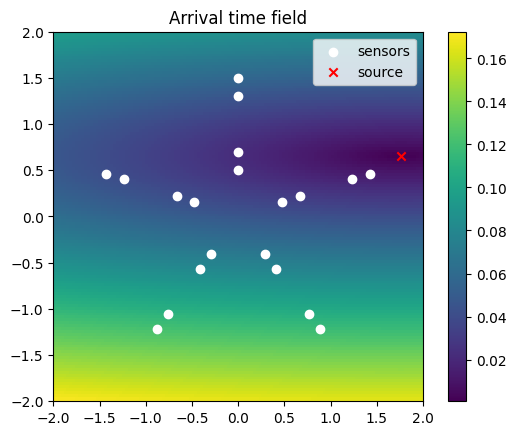

In [5]:
problem = SingleSourceProblem.generate_random_instance(velocity=np.array([1.0, 1.0]))
plot_problem(problem)

This kind of plot is deceitful. By looking at it one may infer that the loss function is very regular and the problem is well conditioned. Experiments have shown that the loss function is not convex, otherwise we would have always convergence.

The following plot shows the loss function.

In [6]:
def compute_loss_landscape(problem: SingleSourceProblem, mesh: np.ndarray, loss: AbstractLoss = SquaredLoss()):
    xx, yy = np.meshgrid(mesh, mesh)

    R = residual(
        problem=problem,
        x=np.array([xx, yy]).T
    )

    return loss(R).T

In [7]:
def plot_loss(problem: SingleSourceProblem, loss: AbstractLoss = SquaredLoss(), resolution: int = 256):
    mesh = np.linspace(-L, L, num=resolution)
    landscape = compute_loss_landscape(problem, mesh, loss)

    plt.pcolormesh(mesh, mesh, landscape)

    plt.scatter(
        problem.sensor_locations[:,0],
        problem.sensor_locations[:,1],
        marker='o',
        color='w',
        label='sensors'
    )
    plt.scatter(
        problem.source_location[0],
        problem.source_location[1],
        marker='x',
        color='r',
        label='source'
    )

    plt.xlim((-L,L))
    plt.ylim((-L,L))
    plt.title(f"{loss} landscape")
    plt.legend()
    plt.gca().set_aspect('equal')
    plt.show()

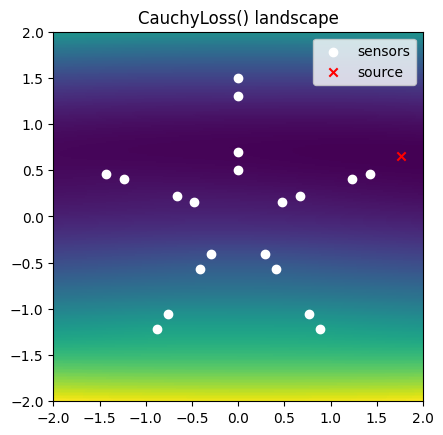

In [8]:
plot_loss(problem, loss=CauchyLoss())

In [11]:
def plot_loss_contour(problem: SingleSourceProblem, loss: AbstractLoss = SquaredLoss(), resolution: int = 256, nlevels: int = 10):
    mesh = np.linspace(-L, L, num=resolution)
    landscape = compute_loss_landscape(problem, mesh, loss)

    min_energy = np.min(landscape)
    max_energy = np.max(landscape)

    energy_levels = min_energy + 2.0**(-np.arange(nlevels)) * (max_energy - min_energy)
    energy_levels = energy_levels[::-1]

    plt.contour(
        mesh,
        mesh,
        landscape,
        levels=energy_levels,
        zorder=0
    )

    plt.scatter(
        problem.source_location[0],
        problem.source_location[1],
        marker='x',
        color='r',
        label='source',
        zorder=10
    )

    plt.xlim((-L,L))
    plt.ylim((-L,L))
    plt.title(f"{loss} landscape")
    plt.legend()
    plt.gca().set_aspect('equal')
    plt.show()

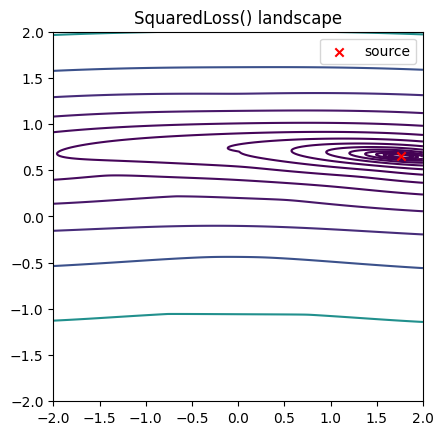

In [13]:
plot_loss_contour(problem, resolution=512, nlevels=15)

# Optimization
The solution of the problem satisfy simultaneously all the sensor constraints. Since there may be errors, we say that the solution satisfy the non linear system in a **least squares** sense.

Selecting an appropriate loss function is critical in the presence of outliers (the goal of this notebook). In that case, alternative loss functions like Cauchy attenuate the contribution of the outliers.

$$ \mathcal{L}(x, y) = \frac{1}{N} \sum_{i=1}^{N} \rho(T_i - \sqrt{(\frac{x - x_i}{v_x})^2 + (\frac{y - y_i}{v_y})^2}) $$

## Optimization in the presence of outliers
By injecting an error on a random sensor, the loss function changes (and so the optimal point)

A simple simulation shows the effect on the solution error as a function of the injected error. The choice of the loss function is critical for being robust to outliers

In [17]:
def sample_solver_robustness(nruns_per_bin: int, sigmas, outliers, solver: AbstractSolver):
    errors = np.zeros(len(sigmas))
    acc = np.zeros(nruns_per_bin)

    for (i, sigma) in enumerate(sigmas):
        for j in range(nruns_per_bin):
            perturbed_problem = generate_problem_instance(
                outliers,
                sigma,
            )

            expected_source_location = solver.solve(
                perturbed_problem,
                x0=np.zeros(2)
            ).x

            err = expected_source_location - perturbed_problem.source_location
            acc[j] = np.linalg.norm(err)

        errors[i] = np.mean(acc)

    return errors

In [18]:
def test_solver_robustness(nruns_per_bin: int, sigmas, outliers, solvers: list[AbstractSolver]):
    for solver in solvers:
        errors = sample_solver_robustness(
            nruns_per_bin,
            sigmas,
            outliers,
            solver
        )
        
        plt.loglog(sigmas, errors, marker='o', label=str(solver))

    plt.xlabel('$\\sigma$')
    plt.ylabel('abs err')
    plt.title(f"Solver robustness for {outliers}/{SENSOR_LOCATIONS.shape[0]} outliers")
    plt.legend()
    plt.show()

### Least squares solvers
The following test are done on variations of the `scipy.optimize.least_squares` routine.

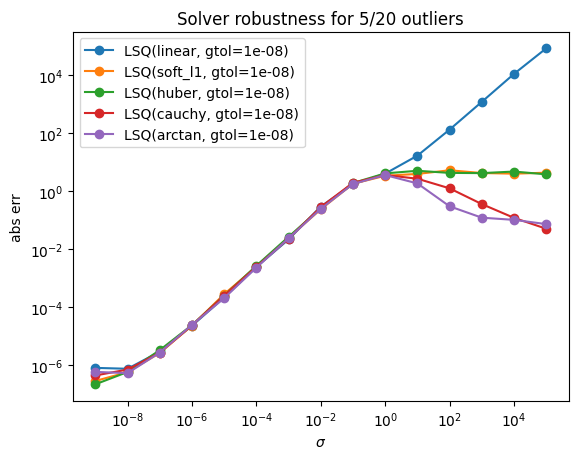

In [19]:
test_solver_robustness(
    nruns_per_bin=200,
    sigmas=10.0**np.arange(-9,6),
    outliers=5,
    solvers=[
        LeastSquaresSolver('linear'),
        LeastSquaresSolver('soft_l1'),
        LeastSquaresSolver('huber'),
        LeastSquaresSolver('cauchy'),
        LeastSquaresSolver('arctan'),
    ]
)

## Using "robust" optimizers
I'm interested in improving the error bounds for the least squares optimizers. This problem is hard because an optimizer is only good as its loss (*).

As changing the loss has effect on the final error, the next step is removing the outlier contributions to the loss. I found experimentally that the residuals after the first optimization pass are estimators (qualitative) of the perturbation injected in the arrival times.

Residuals are clustered around the origin, except for outliers. The quality of the outlier detection method will affect the final error. I provide a lower bound for the error by implementing a solver that has 100% accuracy on outlier detection.

In [25]:
def sample_small_problem_optimization(
    nruns_per_bin: int,
    sensor_sizes: list[int],
    solver: AbstractSolver,
    shitty_problems : list[SingleSourceProblem]= None):

    errors = np.zeros(len(sensor_sizes))

    for (i, sensor_size) in enumerate(sensor_sizes):
        local_errors = np.zeros(nruns_per_bin)

        for j in range(nruns_per_bin):
            original_problem = generate_problem_instance()
            small_problem = original_problem.get_small_problem(sensor_size)

            optimize_result = solver.solve(
                small_problem,
                x0=np.zeros(2)
            )

            assert(optimize_result.success)

            expected_source_location = optimize_result.x
            err = np.linalg.norm(expected_source_location - small_problem.source_location)

            print(err)

            if err > 1e-2 and shitty_problems is not None:
                shitty_problems.append(small_problem)

            local_errors[j] = err

        errors[i] = np.median(local_errors)

    return errors

In [26]:
def test_small_problem_optimization(
    nruns_per_bin: int,
    sensor_sizes: list[int],
    solvers: list[AbstractSolver],
    shitty_problems : list[SingleSourceProblem] = None):

    for solver in solvers:
        errors = sample_small_problem_optimization(
            nruns_per_bin,
            sensor_sizes,
            solver,
            shitty_problems
        )
        
        plt.semilogy(sensor_sizes, errors, marker='o', label=str(solver))

    plt.xticks(sensor_sizes)
    plt.xlabel('# sensors')
    plt.ylabel('avg $|| x - x_{opt} ||$')
    plt.title("Errors when solving smaller problems")
    plt.legend()
    plt.show()

1.507166987491572e-09
6.727942934154773e-11
4.092596745122188e-08
8.14048931100971e-09
5.248515758719431e-10
5.347649647080501e-07
1.4335316727837086e-07
6.730735091546908
2.250224542180391e-07
2.4195472355584494e-07
1.1296813634198764e-05
4.689295972359946e-11
3.0709784891319145e-06
5.662480874972881e-07
1.849042657442049e-10
1.9500480558016922
9.942586506800233e-07
2.0134282289102706e-11
2.2341016673999303e-08
9.351535014103513e-10
3.134560041830653e-08
4.179860992665265e-07
9.16711545324011e-07
2.3053607886755921e-07
3.904432356776595e-06
2.5434688541751227e-12
3.4273374429818605e-10
3.0567631638051065
8.634097262313965e-07
3.0689063337500873e-07
3.2992950696384364e-06
2.431512676141293e-08
6.514561563383736e-07
2.5371479946768916
6.669872223007621
2.152411963063613e-09
1.6182666381024386e-06
5.7658266377180224e-05
1.4706011116918902e-10
1.8529461076429301e-06
6.1530969077534385e-09
2.44063127839591e-08
0.49684464265666556
1.344763208495189e-05
9.775790672506616e-06
2.56851560055730

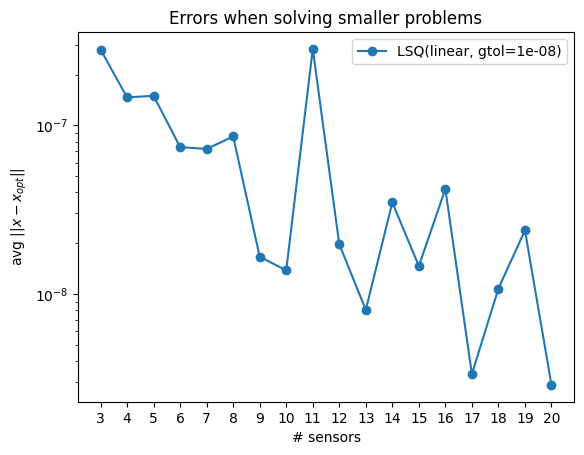

In [27]:
shitty_problems = []

test_small_problem_optimization(
    nruns_per_bin=50,
    sensor_sizes=np.arange(3, SENSOR_LOCATIONS.shape[0]+1),
    solvers=[
        LeastSquaresSolver(),
    ],
    shitty_problems=shitty_problems
)

I really don't like this plot. I hope there is a problem in the optimization procedure otherwise this source location problem is very ill-conditioned.

Here is a possible explanation of the phenomena, excluding implementation bugs. The problem is ill conditioned, so even with small residuals the solution is far from the optimal point. The residuals alone don't give a complete idea of what's going on. I suspect all the iterations are stopped by the `gtol` condition

### Explaining why the optimizer suck

In [24]:
LeastSquaresSolver().solve(shitty_problems[0], np.zeros(2))

     message: `gtol` termination condition is satisfied.
     success: True
      status: 1
         fun: [-5.312e-03  4.113e-03 -2.159e-03]
           x: [-5.761e-01 -5.915e-01]
        cost: 2.4899754937305906e-05
         jac: [[ 4.436e-03  5.843e-02]
               [ 8.514e-03  4.576e-02]
               [ 5.305e-03 -5.659e-02]]
        grad: [-2.772e-10  2.432e-09]
  optimality: 2.432184191758979e-09
 active_mask: [ 0.000e+00  0.000e+00]
        nfev: 10
        njev: 10

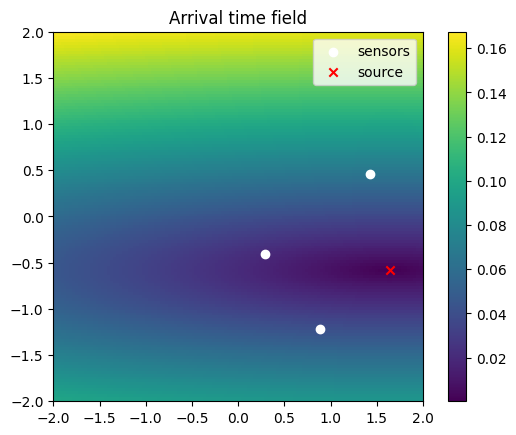

In [23]:
plot_problem(shitty_problems[0])